# DGA Domain Detection using Deep Learning
## Binary Classification: Legitimate vs DGA-generated Domains

This notebook implements a deep learning model using NLP techniques to detect Domain Generation Algorithm (DGA) generated domains.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


## 2. Load and Explore the Data

In [3]:
# Load datasets
dga_df = pd.read_csv('dga_websites.csv')
legit_df = pd.read_csv('legit_websites.csv')

print("DGA Dataset Shape:", dga_df.shape)
print("Legitimate Dataset Shape:", legit_df.shape)
print("\nFirst few DGA domains:")
print(dga_df.head())
print("\nFirst few legitimate domains:")
print(legit_df.head())

DGA Dataset Shape: (337500, 2)
Legitimate Dataset Shape: (337398, 2)

First few DGA domains:
  class                   domain
0   dga       mortiscontrastatim
1   dga  cvyh1po636avyrsxebwbkn7
2   dga           txumyqrubwutbb
3   dga            ixekrihagimau
4   dga         rjyuosmhfnaedlyg

First few legitimate domains:
   class               domain
0  legit          plasticbags
1  legit             mzltrack
2  legit            miss-slim
3  legit        myhostingpack
4  legit  download-by-satoshi


In [4]:
# Combine datasets
df = pd.concat([dga_df, legit_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nClass distribution (%)")
print(df['class'].value_counts(normalize=True) * 100)

Total samples: 674898

Class distribution:
class
dga      337500
legit    337398
Name: count, dtype: int64

Class distribution (%)
class
dga      50.007557
legit    49.992443
Name: proportion, dtype: float64


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Remove any missing values if present
df = df.dropna()

# Convert class to binary: legit=0, dga=1
df['label'] = df['class'].map({'legit': 0, 'dga': 1})

print("\nData after preprocessing:")
print(df.head())

Missing values:
class     0
domain    0
dtype: int64

Data after preprocessing:
   class                domain  label
0    dga   5xs2m8mdonafeh16s4o      1
1    dga         hojfkwygbuowd      1
2  legit                  chqt      0
3  legit  einhell-werksverkauf      0
4  legit   thetrafficticketman      0


## 3. Exploratory Data Analysis

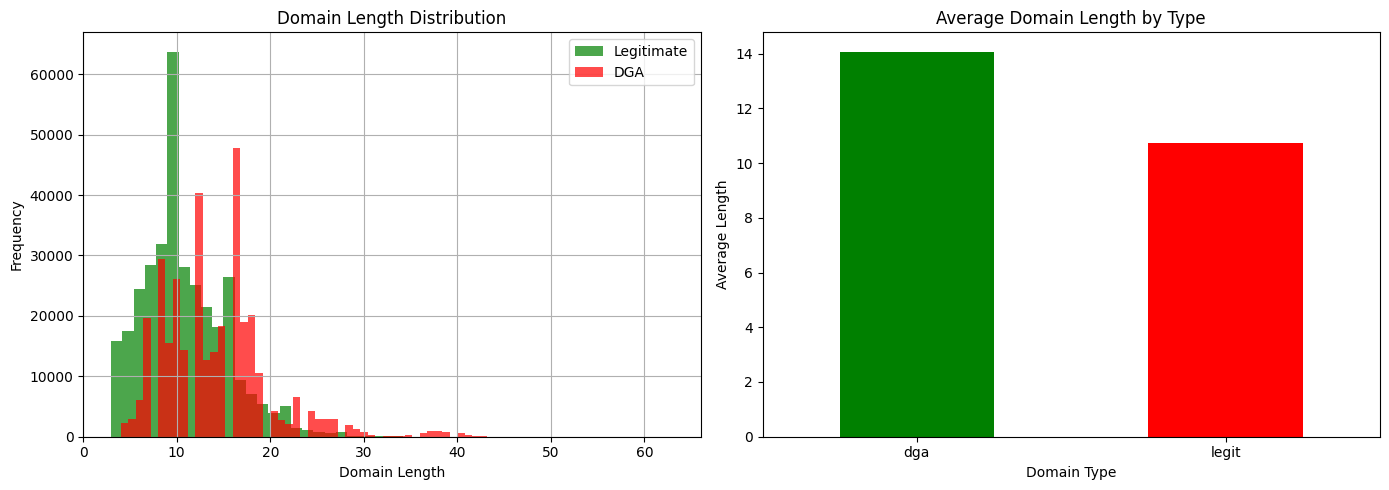

Domain length statistics:
          count       mean       std  min   25%   50%   75%   max
class                                                            
dga    337500.0  14.075197  5.816747  4.0  10.0  13.0  17.0  44.0
legit  337398.0  10.726403  4.530915  3.0   7.0  10.0  13.0  63.0


In [6]:
# Domain length analysis
df['domain_length'] = df['domain'].apply(len)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df[df['class'] == 'legit']['domain_length'].hist(bins=50, alpha=0.7, label='Legitimate', color='green')
df[df['class'] == 'dga']['domain_length'].hist(bins=50, alpha=0.7, label='DGA', color='red')
plt.xlabel('Domain Length')
plt.ylabel('Frequency')
plt.title('Domain Length Distribution')
plt.legend()

plt.subplot(1, 2, 2)
df.groupby('class')['domain_length'].mean().plot(kind='bar', color=['green', 'red'])
plt.xlabel('Domain Type')
plt.ylabel('Average Length')
plt.title('Average Domain Length by Type')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("Domain length statistics:")
print(df.groupby('class')['domain_length'].describe())

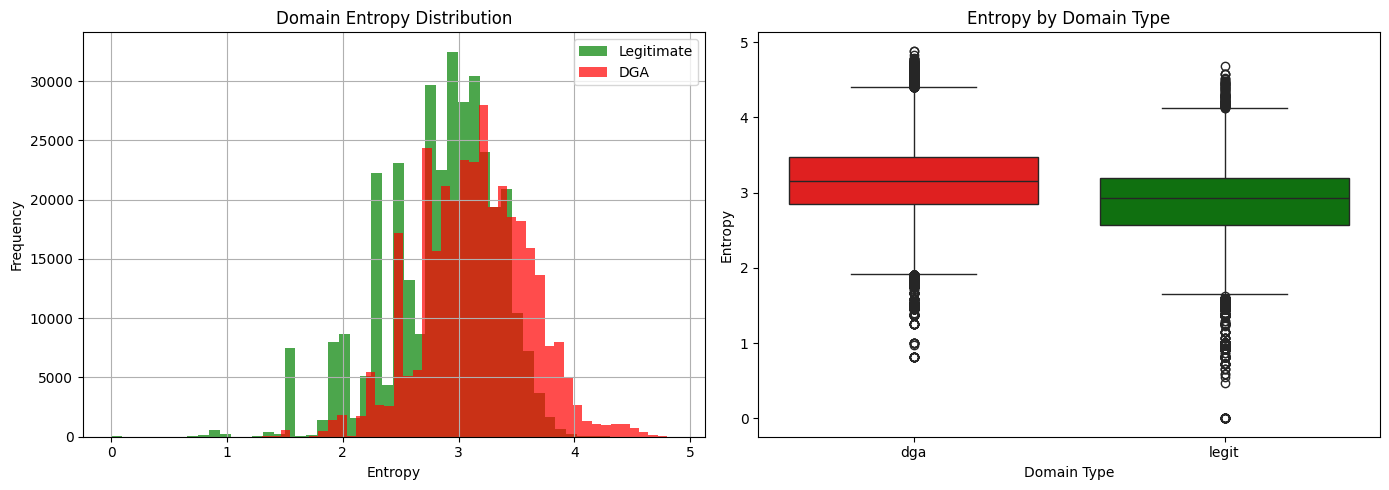

In [7]:
# Character distribution analysis
def calculate_entropy(domain):
    """Calculate Shannon entropy of domain"""
    prob = [float(domain.count(c)) / len(domain) for c in set(domain)]
    entropy = -sum([p * np.log2(p) for p in prob])
    return entropy

df['entropy'] = df['domain'].apply(calculate_entropy)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df[df['class'] == 'legit']['entropy'].hist(bins=50, alpha=0.7, label='Legitimate', color='green')
df[df['class'] == 'dga']['entropy'].hist(bins=50, alpha=0.7, label='DGA', color='red')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Domain Entropy Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='class', y='entropy', palette={'legit': 'green', 'dga': 'red'})
plt.title('Entropy by Domain Type')
plt.xlabel('Domain Type')
plt.ylabel('Entropy')

plt.tight_layout()
plt.show()

## 4. Text Preprocessing and Tokenization

In [8]:
# Character-level tokenization (treating each character as a token)
def char_tokenize(domain):
    """Convert domain to space-separated characters"""
    return ' '.join(list(domain))

df['char_tokens'] = df['domain'].apply(char_tokenize)

print("Example of character tokenization:")
print(f"Original: {df['domain'].iloc[0]}")
print(f"Tokenized: {df['char_tokens'].iloc[0]}")

Example of character tokenization:
Original: 5xs2m8mdonafeh16s4o
Tokenized: 5 x s 2 m 8 m d o n a f e h 1 6 s 4 o


In [9]:
# Prepare data for modeling
X = df['char_tokens'].values
y = df['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())

Training samples: 539918
Testing samples: 134980

Training set class distribution:
1    270000
0    269918
Name: count, dtype: int64


In [10]:
# Tokenize the text data
max_features = 50  # Number of unique characters (a-z, 0-9, special chars)
max_length = 75    # Maximum sequence length

tokenizer = Tokenizer(char_level=True, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape: {X_test_pad.shape}")
print(f"\nExample sequence (first domain):")
print(f"Original: {X_train[0]}")
print(f"Sequence: {X_train_seq[0][:20]}...")  # Show first 20 characters

Vocabulary size: 40
Training data shape: (539918, 75)
Testing data shape: (134980, 75)

Example sequence (first domain):
Original: g a n a c h e m
Sequence: [16, 2, 4, 2, 9, 2, 4, 2, 11, 2, 18, 2, 3, 2, 14]...


## 5. Build Deep Learning Model

In [11]:
# Model architecture: Hybrid CNN-LSTM
def build_dga_detector(vocab_size, max_length, embedding_dim=64):
    """
    Build a hybrid CNN-LSTM model for DGA detection
    
    Architecture:
    1. Embedding layer for character representation
    2. Conv1D layers for local pattern detection
    3. Bidirectional LSTM for sequential dependencies
    4. Dense layers for classification
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        
        # Convolutional layers for n-gram feature extraction
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Bidirectional LSTM for sequence learning
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.4),
        
        # Dense layers for classification
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Build the model
vocab_size = len(tokenizer.word_index) + 1
model = build_dga_detector(vocab_size, max_length)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [12]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_dga_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Train the model
batch_size = 128
epochs = 20

print("Starting model training...")
history = model.fit(
    X_train_pad, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
print("\nTraining completed!")

Starting model training...
Epoch 1/20
3373/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8323 - auc: 0.8999 - loss: 0.3710 - precision: 0.8807 - recall: 0.7706
Epoch 1: val_accuracy improved from -inf to 0.89987, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 185s 51ms/step - accuracy: 0.8323 - auc: 0.8999 - loss: 0.3709 - precision: 0.8808 - recall: 0.7707 - val_accuracy: 0.8999 - val_auc: 0.9608 - val_loss: 0.2419 - val_precision: 0.9293 - val_recall: 0.8653 - learning_rate: 0.0010
Epoch 2/20
3374/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8929 - auc: 0.9541 - loss: 0.2612 - precision: 0.9234 - recall: 0.8573
Epoch 2: val_accuracy improved from 0.89987 to 0.91666, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 146s 43ms/step - accuracy: 0.8929 - auc: 0.9541 - loss: 0.2611 - precision: 0.9234 - recall: 0.8573 - val_accuracy: 0.9167 - val_auc: 0.9723 - val_loss: 0.2053 - val_precision: 0.9405 - val_recall: 0.8894 - learning_rate: 0.0010
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9041 - auc: 0.9632 - loss: 0.2356 - precision: 0.9320 - recall: 0.8722
Epoch 3: val_accuracy improved from 0.91666 to 0.92252, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 146s 43ms/step - accuracy: 0.9041 - auc: 0.9632 - loss: 0.2356 - precision: 0.9320 - recall: 0.8722 - val_accuracy: 0.9225 - val_auc: 0.9771 - val_loss: 0.1894 - val_precision: 0.9299 - val_recall: 0.9137 - learning_rate: 0.0010
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9112 - auc: 0.9683 - loss: 0.2195 - precision: 0.9370 - recall: 0.8820
Epoch 4: val_accuracy improved from 0.92252 to 0.92803, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 147s 44ms/step - accuracy: 0.9112 - auc: 0.9683 - loss: 0.2195 - precision: 0.9370 - recall: 0.8820 - val_accuracy: 0.9280 - val_auc: 0.9800 - val_loss: 0.1770 - val_precision: 0.9398 - val_recall: 0.9144 - learning_rate: 0.0010
Epoch 5/20
3374/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9145 - auc: 0.9715 - loss: 0.2091 - precision: 0.9390 - recall: 0.8870
Epoch 5: val_accuracy improved from 0.92803 to 0.93436, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 143s 42ms/step - accuracy: 0.9145 - auc: 0.9715 - loss: 0.2091 - precision: 0.9390 - recall: 0.8870 - val_accuracy: 0.9344 - val_auc: 0.9827 - val_loss: 0.1653 - val_precision: 0.9430 - val_recall: 0.9244 - learning_rate: 0.0010
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9191 - auc: 0.9742 - loss: 0.1992 - precision: 0.9396 - recall: 0.8961
Epoch 6: val_accuracy improved from 0.93436 to 0.93723, saving model to best_dga_model.h5


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 148s 44ms/step - accuracy: 0.9191 - auc: 0.9742 - loss: 0.1992 - precision: 0.9396 - recall: 0.8961 - val_accuracy: 0.9372 - val_auc: 0.9842 - val_loss: 0.1584 - val_precision: 0.9423 - val_recall: 0.9314 - learning_rate: 0.0010
Epoch 7/20
2923/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9224 - auc: 0.9759 - loss: 0.1926 - precision: 0.9423 - recall: 0.9003

## 7. Evaluate Model Performance

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Validation AUC')
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision and Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision')
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test_pad, y_test, verbose=0)

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print("="*50)

In [ ]:
# Make predictions
y_pred_proba = model.predict(X_test_pad, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'DGA']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'DGA'], 
            yticklabels=['Legitimate', 'DGA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrue Negatives:  {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives:  {cm[1][1]}")

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

## 8. Test Model with Sample Predictions

In [ ]:
def predict_domain(domain, model, tokenizer, max_length):
    """
    Predict if a domain is legitimate or DGA-generated
    """
    # Tokenize domain
    char_tokens = ' '.join(list(domain))
    sequence = tokenizer.texts_to_sequences([char_tokens])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Make prediction
    prediction = model.predict(padded, verbose=0)[0][0]
    
    # Interpret result
    label = "DGA" if prediction > 0.5 else "Legitimate"
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    
    return label, confidence, prediction

# Test with sample domains
test_domains = [
    "google",
    "facebook",
    "amazon",
    "xjfkdslfjkdslfj",
    "qwertyasdfgh",
    "microsoft",
    "apple",
    "zgxcnmvbnmcvb",
    "youtube",
    "github"
]

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)
print(f"{'Domain':<25} {'Prediction':<15} {'Confidence':<15} {'Score':<10}")
print("-"*70)

for domain in test_domains:
    label, confidence, score = predict_domain(domain, model, tokenizer, max_length)
    print(f"{domain:<25} {label:<15} {confidence*100:>6.2f}%         {score:.4f}")

print("="*70)

## 9. Save the Model and Tokenizer

In [ ]:
# Save the trained model
model.save('dga_detector_model.h5')
print("✓ Model saved as 'dga_detector_model.h5'")

# Save model in SavedModel format (for TensorFlow Serving)
model.save('dga_detector_model_savedmodel', save_format='tf')
print("✓ Model saved in SavedModel format")

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved as 'tokenizer.pkl'")

# Save model configuration
model_config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'threshold': 0.5
}

with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✓ Model configuration saved as 'model_config.pkl'")

print("\n" + "="*50)
print("All model artifacts saved successfully!")
print("="*50)
print("\nFiles created:")
print("  - dga_detector_model.h5 (Keras model)")
print("  - dga_detector_model_savedmodel/ (TensorFlow SavedModel)")
print("  - tokenizer.pkl (Character tokenizer)")
print("  - model_config.pkl (Model configuration)")
print("  - best_dga_model.h5 (Best checkpoint)")
print("  - training_history.png (Training plots)")
print("  - confusion_matrix.png (Confusion matrix)")
print("  - roc_curve.png (ROC curve)")

## 10. Model Summary and Conclusion

In [ ]:
print("\n" + "="*70)
print("FINAL MODEL SUMMARY")
print("="*70)
print(f"\nModel Architecture: Hybrid CNN-LSTM")
print(f"Total Parameters: {model.count_params():,}")
print(f"\nDataset Information:")
print(f"  - Total samples: {len(df):,}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Testing samples: {len(X_test):,}")
print(f"\nModel Performance:")
print(f"  - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  - Test AUC: {test_auc:.4f}")
print(f"  - Test Precision: {test_precision:.4f}")
print(f"  - Test Recall: {test_recall:.4f}")
print(f"\nKey Features:")
print(f"  - Character-level NLP tokenization")
print(f"  - Convolutional layers for pattern detection")
print(f"  - Bidirectional LSTM for sequence learning")
print(f"  - Dropout regularization to prevent overfitting")
print(f"  - Early stopping and learning rate scheduling")
print("\n" + "="*70)
print("Model is ready for deployment!")
print("="*70)